# Guerlédan seabot data analysis: 2024/10

In [2]:
import os
from glob import glob

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#%matplotlib inline
plt.rc('figure', titlesize=10)
plt.rc('axes', titlesize=10)
import hvplot.pandas # noqa
from cmocean import cm

import pynsitu as pin
import cognac.ufloat as fl
import seabot as sb
crs = sb.crs

show_hv=True
#show_hv=False

## load data

In [3]:
#root_path = "/Users/aponte/Current_Projects/ensta/guerledan_202310/data_seabot"
root_dir = "/Users/aponte/Current_Projects/ensta/guerledan/"

seabot_dir = os.path.join(root_dir, "202410/data_seabot")
#seabot_dir = os.path.join(root_dir, "202410/data_seabot/test_guerledan_2024_10_11")
cp_yml = "guerledan_202410.yaml"

# load seabot
D = sb.walk_load_repo(seabot_dir)

/Users/aponte/Current_Projects/ensta/guerledan/202410/data_seabot/test_guerledan_2024_10_08/seabot1/rosbag2_2024_10_08-18_52_03
/Users/aponte/Current_Projects/ensta/guerledan/202410/data_seabot/test_guerledan_2024_10_08/seabot2/rosbag2_2024_10_08-18_52_33
/Users/aponte/Current_Projects/ensta/guerledan/202410/data_seabot/test_guerledan_2024_10_08/seabot3/rosbag2_2024_10_08-11_43_46
/Users/aponte/Current_Projects/ensta/guerledan/202410/data_seabot/test_guerledan_2024_10_08/seabot4/rosbag2_2024_10_08-18_53_51
/Users/aponte/Current_Projects/ensta/guerledan/202410/data_seabot/test_guerledan_2024_10_08/seabot5/rosbag2_2024_10_08-18_54_01
/Users/aponte/Current_Projects/ensta/guerledan/202410/data_seabot/test_guerledan_2024_10_10a/seabot3/rosbag2_2024_10_09-17_25_08
/Users/aponte/Current_Projects/ensta/guerledan/202410/data_seabot/test_guerledan_2024_10_10a/seabot4/rosbag2_2024_10_10-08_13_03
/Users/aponte/Current_Projects/ensta/guerledan/202410/data_seabot/test_guerledan_2024_10_10a/seabot5/r

In [4]:
# load yaml file and match/filter data
cp = pin.Campaign(cp_yml)
M, iM = sb.match_filter_with_cp(D, cp)
iM

{('test_guerledan_2024_10_08', 'seabot1'): ('seabot1', 'isoT0'),
 ('test_guerledan_2024_10_10b', 'seabot1'): ('seabot1', 'isoT2'),
 ('test_guerledan_2024_10_11', 'seabotX'): ('seabot1', 'freeZ'),
 ('test_guerledan_2024_10_08', 'seabot2'): ('seabot2', 'scanZ0'),
 ('test_guerledan_2024_10_10b', 'seabot2'): ('seabot2', 'isoT2'),
 ('test_guerledan_2024_10_08', 'seabot3'): ('seabot3', 'scanZ0'),
 ('test_guerledan_2024_10_10a', 'seabot3'): ('seabot3', 'isoZ1'),
 ('test_guerledan_2024_10_10b', 'seabot3'): ('seabot3', 'isoT2'),
 ('test_guerledan_2024_10_08', 'seabot4'): ('seabot4', 'isoT0'),
 ('test_guerledan_2024_10_10a', 'seabot4'): ('seabot4', 'scanZ1'),
 ('test_guerledan_2024_10_10b', 'seabot4'): ('seabot4', 'isoT2'),
 ('test_guerledan_2024_10_08', 'seabot5'): ('seabot5', 'scanZ0'),
 ('test_guerledan_2024_10_10a', 'seabot5'): ('seabot5', 'isoT1'),
 ('test_guerledan_2024_10_10b', 'seabot5'): ('seabot5', 'isoT2')}

In [5]:
# extract relevant data sets
Dk = sb.dfilter(D, "observer_kalman")
Dd = sb.dfilter(D, "observer_depth")
#Dpiston = sb.dfilter(D, "driver_piston")

#colors = {d: c for d, c in zip(list(Dk), pin.get_cmap_colors(len(Dk)))}
colors = {d: cp[iM[d][0]]["color"] if d in iM else "k" for d in list(Dk)}

# combine temperature and kalman data
Dc = sb.combine(
    D, "1s", 
    ka="observer_kalman", 
    te="observer_temperature", 
    pi="driver_piston",
    de="observer_depth",
)
# add/massage variables
for d, df in Dc.items():
    # append depth filtered to match temperature
    #sb.append_depth_filtered(df, 2., key="ka_depth")
    sb.append_depth_filtered(df, 2., key="de_depth")
    # append piston displacement and volume
    df["pi_course"], df["pi_volume"] = sb.position2course(df["pi_position"])

---
## profiles of stratification

### load independent CTD profile

In [45]:
ds = cp.load("ctd.nc")
ds["pressure"] = -ds["z"] # tmp fix

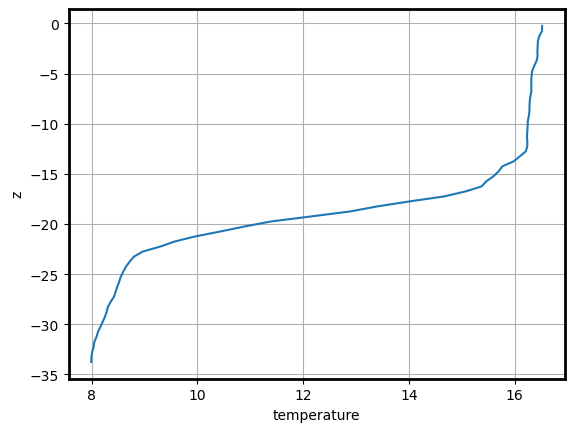

In [46]:
fig, ax = plt.subplots(1,1)
ds["temperature"].plot(y="z")
ax.grid()

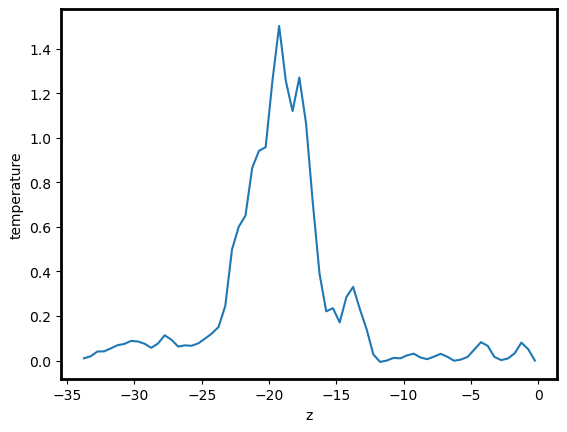

In [47]:
ds["temperature"].differentiate("z").plot()

In [48]:
dTdz = 1. # degC/m

In [49]:
# instantiate float object
f = fl.autonomous_float(model='seabot')
f.init_piston()
f.piston.update_d(5e-2)

# tmp: manually adjust alpha
f.params["alpha"] = 7e-5
f._set_params_as_attrs()

w = fl.waterp(**{v: ds[v].values for v in ["temperature", "salinity", "pressure"]}, lon=sb.g_lon, lat=sb.g_lat)

# check drag consistent with interns' report:
u = .3 # m/s
print(f"Drag force in Newton for u = {u:.2f} m/s: ", -f["m"]*f.get_cd(u, 0.)*u) # drag in Newtons

Piston max volume set from max displacement
Drag force in Newton for u = 0.30 m/s:  -0.6299713199999999


-268.0 g  were added to the float in order to be at equilibrium at 15 dbar 



(174.75, 174.9474408967816)

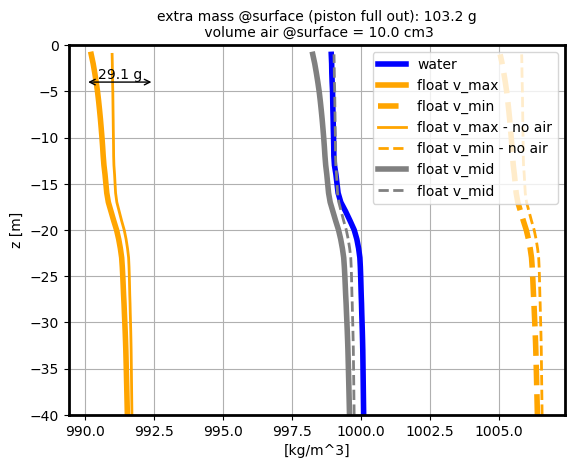

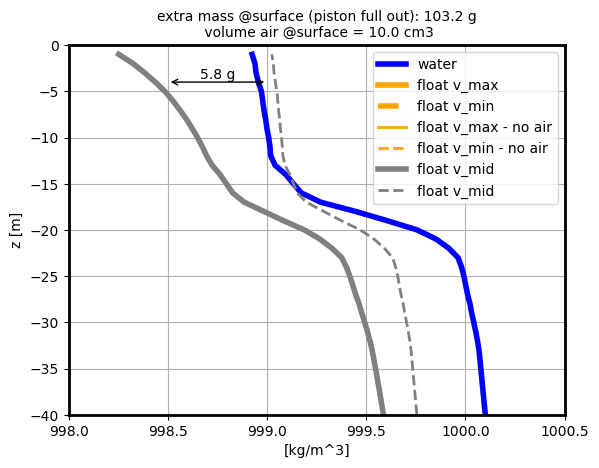

In [50]:
# adjust mass to target one depth
z_equilibrium = -15.
_w = w.at(z=z_equilibrium, extra=True)
rho_w, p, temp, N2 = _w["rho"], _w["pressure"], _w["temperature"], _w["N2"]
f.adjust_m(p, temp, rho_w, offset=0.)

# plot 
z=np.arange(-40.,0.,1.)
v_air = 10
ax = fl.plot_float_density(z, f, w, v_air=v_air*fl.cm3, mid=f.piston.vol, show_no_air=True) #, xlim=(999, 1001))
ax = fl.plot_float_density(z, f, w, v_air=v_air*fl.cm3, mid=f.piston.vol, show_no_air=True, xlim=(998., 1000.5))

# check full volume change available
7.5*23.3, 11e-2*f.piston.A*1000e3 # g

#f.alpha

In [51]:
# base case: depth dependance + at a single depth
H = f.get_transfer_functions(w, 1e-3, (-4, -2), v_air=fl.cm3*0., Ap=f.piston.A)
H1 = f.get_transfer_functions(w, 1e-3, (-4, -2), v_air=fl.cm3*1., Ap=f.piston.A)
H10 = f.get_transfer_functions(w, 1e-3, (-4, -2), v_air=fl.cm3*10., Ap=f.piston.A)
H20 = f.get_transfer_functions(w, 1e-3, (-4, -2), v_air=fl.cm3*20., Ap=f.piston.A)

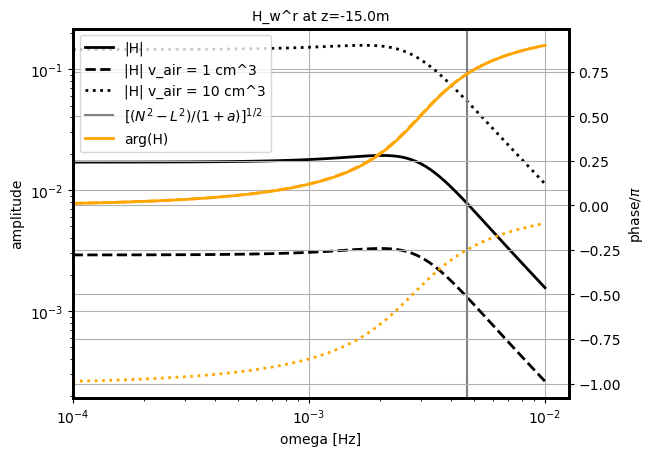

In [52]:
if cp["name"]=="guerledan_202310":
    z_eq = -14
elif cp["name"]=="guerledan_202402":
    z_eq = -13
elif cp["name"]=="guerledan_202410":
    z_eq = -19

Heq = H.sel(z=z_eq, method="nearest")
H1eq = H1.sel(z=z_eq, method="nearest")
H10eq = H10.sel(z=z_eq, method="nearest")
H20eq = H20.sel(z=z_eq, method="nearest")

H_label = "H_w^r"
#H_label = "H_w^f"
#H_label = "H_p^rbis" # looks about the same
da = Heq[H_label]
#dab = Heq["H_w^r"]
da1 = H1eq[H_label]
da10 = H10eq[H_label]
da20 = H20eq[H_label]

fig, ax = plt.subplots(1,1)

h0 = ax.plot(da.omega, np.abs(da), 'k', lw=2, label="|H|")
h0_1 = ax.plot(da1.omega, np.abs(da1), 'k', lw=2, ls="--", label="|H| v_air = 1 cm^3")
h0_10 = ax.plot(da10.omega, np.abs(da10), 'k', lw=2, ls=":", label="|H| v_air = 10 cm^3")
#h0b = ax.plot(da.omega, np.abs(dab), 'b', lw=2, label="|H|")
h1 = ax.axvline(np.sqrt((Heq.N2)/(1+f.a))/2/np.pi, color="0.5", ls="-", label=r"$[(N^2-L^2)/(1+a)]^{1/2}$")
#ax.axvline(np.sqrt((Heq.N2-Heq.L2)/(1+f.a))/2/np.pi, color="0.5", ls="--")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(f"{H_label} at z={z_equilibrium:.1f}m")
ax.set_xlabel("omega [Hz]")
ax.set_ylabel("amplitude")

axp = ax.twinx()
angles = np.unwrap(np.angle(da))/np.pi
h2 = axp.plot(da.omega, angles, 'orange', lw=2, label="arg(H)")
angles1 = np.unwrap(np.angle(da1))/np.pi
h2_1 = axp.plot(da1.omega, angles1, 'orange', lw=2, ls="--", label="arg(H)")
angles10 = np.unwrap(np.angle(da10))/np.pi
h2_10 = axp.plot(da10.omega, angles10, 'orange', lw=2, ls=":", label="arg(H)")
ax.grid()
axp.grid()
axp.set_ylabel(r"phase/$\pi$")

ax.set_xlim(1e-4, None)

axp.legend(handles=[h0[0], h0_1[0], h0_10[0], h1, h2[0]], loc=2)

Text(0.5, 1.0, 'mean(M2-N2+L2)=1.19e-05')

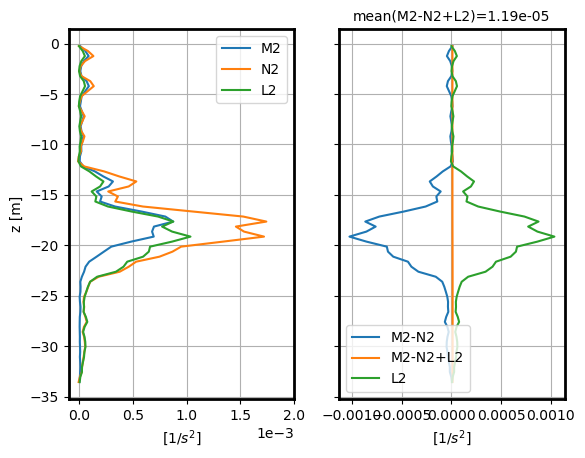

In [53]:
fig, axes = plt.subplots(1,2, sharey=True)

ax = axes[0]
ax.plot(H.M2, H.z, label="M2")
ax.plot(H.N2, H.z, label="N2")
ax.plot(H.L2, H.z, label="L2")
ax.legend()
ax.ticklabel_format(axis='x', scilimits=[-3, 3])
ax.grid()
ax.set_ylabel("z [m]")
ax.set_xlabel(r"$[1/s^2]$")
ax.set_xlim(None,2e-3)

ax = axes[1]
ax.plot(H.M2-H.N2, H.z, label="M2-N2")
ax.plot(H.M2-H.N2+H.L2, H.z, label="M2-N2+L2")
ax.plot(H.L2, H.z, label="L2")
#ax.plot(f, H.z, label="L2")
ax.legend(loc=3)
ax.grid()
ax.set_xlabel(r"$[1/s^2]$")
_mean = (H.M2-H.N2+H.L2).mean()
ax.set_title(f"mean(M2-N2+L2)={_mean:.2e}")

(-0.0017148103453554818, 0.002)

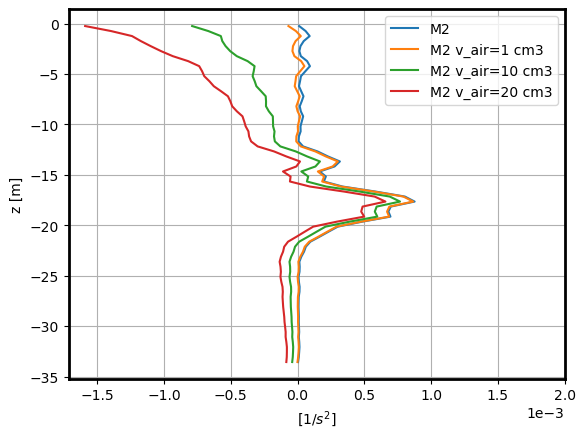

In [54]:
fig, axes = plt.subplots(1,1, sharey=True)

ax = axes
ax.plot(H.M2, H.z, label="M2")
ax.plot(H1.M2, H.z, label="M2 v_air=1 cm3")
ax.plot(H10.M2, H.z, label="M2 v_air=10 cm3")
ax.plot(H20.M2, H.z, label="M2 v_air=20 cm3")
ax.legend()
ax.ticklabel_format(axis='x', scilimits=[-3, 3])
ax.grid()
ax.set_ylabel("z [m]")
ax.set_xlabel(r"$[1/s^2]$")
ax.set_xlim(None,2e-3)

The natural stability of the float is governed by the sign of $M^2$ which depends on the amount of trapped air.
In the thermocline, stratification is sufficiently strong to ensure stability.

A low frequencies, the amplitude of relative motions may be weak because of the stratification but will still remain modulated by difference of compressibility (and the volume of trapped air in the upper 10's of meters): $(M^2 - N^2 + L^2)/M^2 = (\gamma_w + \alpha_f \Gamma_w - \gamma_f)/M^2$. 
For volumes of trapped air exceeding a couple of cm$^3$, the volume of trapped air may thus directly modulate the low frequency response.

Text(0.5, 1.0, 'compressibilities')

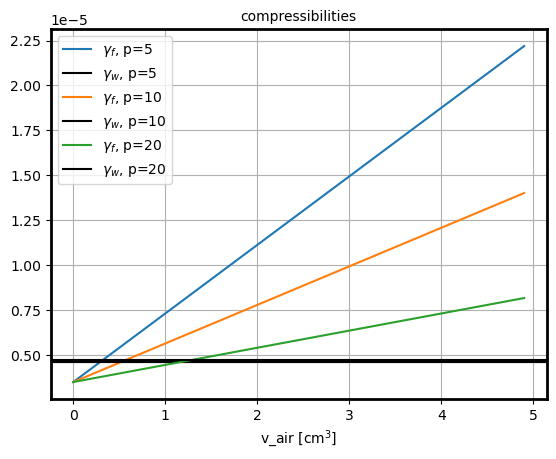

In [34]:
v_air = np.arange(0,5,.1)

fig, ax = plt.subplots(1, 1)

for _p in [5, 10, 20]:
    #_p = 20 # dbar
    _w = w.at(z=-_p, extra=True)
    ax.plot(v_air, f.get_gamma(v_air=v_air*fl.cm3, p=_p), label=f"$\gamma_f$, p={_p}")
    ax.axhline(_w["kappa"], color="k", label=f"$\gamma_w$, p={_p}")
ax.grid()
ax.legend()
ax.set_xlabel("v_air [cm$^3$]")
ax.set_title("compressibilities")

---

## isotherm/isodepth  missions

In [10]:
# select drift or scan period
Dcore = {}
for plabel, p in cp.platforms.items():
    for d in p["deployments"]:
        meta = cp[plabel][d].meta
        if "core_start" in meta:
            print(plabel,d)
            key = M[(plabel, d)]
            if key in Dc:
                Dcore[key] = Dc[key].loc[meta["core_start"]:meta["core_end"]]

seabot1 isoT0
seabot1 isoT2
seabot1 freeZ
seabot2 scanZ0
seabot2 isoT2
seabot3 scanZ0
seabot3 isoZ1
seabot3 isoT2
seabot4 isoT0
seabot4 scanZ1
seabot4 isoT2
seabot5 scanZ0
seabot5 isoT1
seabot5 isoT2


In [11]:
iso_T, scan_T = [], []
iso_Z, scan_Z = [], []

for plabel, p in cp.platforms.items():
    for d in p["deployments"]:
        if "isoT" in d:
            iso_T.append(M[(plabel, d)])
        if "scanT" in d:
            scan_T.append(M[(plabel, d)])
        if "isoZ" in d:
            iso_Z.append(M[(plabel, d)])
        if "scanZ" in d:
            scan_Z.append(M[(plabel, d)])

In [14]:
# buid dataset with isothermal displacement

DisoT = {}
for d in iso_T:
    
    df = Dcore[d]
    
    #df["depth_anomaly"] = df["depth"] - df["depth"].mean()
    df["depth_anomaly"] = df["depth_filtered"] - df["depth_filtered"].mean()   # -z_f
    dt = (df.reset_index()["time"].diff().bfill() / pd.Timedelta("1s")).values
    df["velocity_float"] = df["depth_anomaly"].diff().bfill().values / dt   # -dz_f/dt, should be close to "velocity"
    
    if "te_temperature" in df:
        df["temperature_anomaly"] = df["te_temperature"] - df["te_temperature"].mean()

        df["relative_displacement"] = df["temperature_anomaly"]/dTdz  # -(z_w-z_f)
        df["isotherm_displacement"] = df["relative_displacement"] + df["depth_anomaly"]    # -z_w
        # positive downwards
        # compensates for the float vertical displacement

        #df["temperature_rate_of_change"] =  (df["temperature"].diff()).bfill()

        # compute estimated
        #df["velocity_water"] = -df["temperature_rate_of_change"]/dTdz - df["velocity"]    
        df["velocity_water"] = df["isotherm_displacement"].diff().bfill().values / dt      # -dz_w/dt
        df["velocity_relative"] = df["relative_displacement"].diff().bfill().values / dt   # -dz_r/dt
        
    df["pi_course_anomaly"] = df["pi_course"] - df["pi_course"].mean()
    
    DisoT[d] = df

In [15]:
# buid dataset with isothermal displacement

DisoZ = {}
for d in iso_Z:
    
    df = Dcore[d]
    
    #df["depth_anomaly"] = df["depth"] - df["depth"].mean()
    df["depth_anomaly"] = df["depth_filtered"] - df["depth_filtered"].mean()   # -z_f
    dt = (df.reset_index()["time"].diff().bfill() / pd.Timedelta("1s")).values
    df["velocity_float"] = df["depth_anomaly"].diff().bfill().values / dt   # -dz_f/dt, should be close to "velocity"
    
    if "te_temperature" in df:
        df["temperature_anomaly"] = df["te_temperature"] - df["te_temperature"].mean()

        df["relative_displacement"] = df["temperature_anomaly"]/dTdz  # -(z_w-z_f)
        df["isotherm_displacement"] = df["relative_displacement"] + df["depth_anomaly"]    # -z_w
        # positive downwards
        # compensates for the float vertical displacement

        #df["temperature_rate_of_change"] =  (df["temperature"].diff()).bfill()

        # compute estimated
        #df["velocity_water"] = -df["temperature_rate_of_change"]/dTdz - df["velocity"]    
        df["velocity_water"] = df["isotherm_displacement"].diff().bfill().values / dt      # -dz_w/dt
        df["velocity_relative"] = df["relative_displacement"].diff().bfill().values / dt   # -dz_r/dt
        
    df["pi_course_anomaly"] = df["pi_course"] - df["pi_course"].mean()
    
    DisoZ[d] = df

### time series / spectra

In [136]:
def compute_spectrum(df):

    # for latter comparison
    df["depth_difference"] = df["ka_depth"] - df["de_depth"]

    # show mean depth, temperature for this deployment
    print(df["ka_depth"].mean())
    if "te_temperature" in df:
        print(df["te_temperature"].mean())
    
    # tmp before bug fix
    df = df.resample("1s").interpolate()
    
    V =  ['ka_depth', 'ka_velocity',
             'depth_anomaly', 'temperature_anomaly',
             'relative_displacement', 'isotherm_displacement',
             'velocity_water', 'velocity_relative',
             'pi_course', 'pi_course_anomaly',
             'depth_difference', 'de_depth',
            ]
    V = [v for v in V if v in df]
    E = (
        df[V]
        .ts.spectrum(unit="1s", nperseg="2H")
        .to_xarray()
    )
    E = E.where(E.frequency>0, drop=True)
    E.frequency.attrs.update(units="Hz")
    
    E["acceleration"] = E["ka_depth"] * (2*np.pi*E.frequency)**2
    
    return E

In [143]:
Ed_T = {k: compute_spectrum(DisoT[k]) for k in iso_T}
Ed_Z = {k: compute_spectrum(DisoZ[k]) for k in iso_Z}

19.183134101414748
12.002016378822379
19.280787544350066
11.99953773595233
19.14806228050961
11.999405139716883
19.189893283300606
11.999899421596119
19.12253477189994
12.000779967560561
19.20502856997255
11.999606659859664
20.151899677984026
11.999945503967977
19.333103681412172
11.999681204885075
19.00085606095574
12.664325131573431


In [147]:
#key = iso_T[6] # 2023/10
#key = iso_T[1] # 2024/02
key = iso_T[0] # 2024/10
E = Ed_T[key]
df = DisoT[key]

**Notes - Guerlédan 2024/02:**

The float is able to follow low-frequency (> minutes) fluctuations but not higher frequency temperature fluctuations.
This limit may be related to the float natural dynamics and/or regulation response parameters (relaxation feedback constants).

Note that for 5 minutes (0.003 Hz) fluctuations of isotherms, there is a lag of about 50 seconds with the float response but piston displacements do seem heratic (**show Thomas**).

Because of the temperature sensor, we can in theory compensate for this inability to follow isotherm.
This should thus be non-blocking for oceanographic applications.
This is provided internal waves are not "breathing" (dilating stratification).

The vertical velocity associated with high frequency isothermal displacement is about 50 cm / 3 min = 3 mm/s

### compute spectra

In [145]:
# base case: depth dependance + at a single depth
He = f.get_transfer_functions(w, 1e-3, E.frequency.values, v_air=fl.cm3*1., Ap=f.piston.A)
He = He.rename(omega="frequency")
He = He.sel(z=-14, method="nearest")

NameError: name 'E' is not defined

In [152]:
# util

if cp["name"]=="guerledan_202310":
    alpha = 2e-4 # 1/degC
    N = np.sqrt(9.81*alpha*dTdz)
elif cp["name"]=="guerledan_202402":
    N = None
elif cp["name"]=="guerledan_202410":
    N = None
    alpha = 2e-4 # 1/degC
    N = np.sqrt(9.81*alpha*dTdz)


def _add_labels(ax, N=None, legend=True):
    # buoyancy frequency
    #N = np.sqrt( 9.81 * 2e-4 * dTdz )
    if N is None:
        N = np.sqrt(float(He.N2))
    print(f"Buoyancy period = {2*np.pi/N/60:.1f} min")
    ax.axvline(N/2/np.pi, color="k", ls="--")
    ax.text(N/2/np.pi, -.05, 'N', transform=ax.get_xaxis_transform(), ha='center', va='top')
    ax.axvline(1/3600, color="k", ls="--")
    ax.text(1/3600, -.05, '1h', transform=ax.get_xaxis_transform(), ha='center', va='top')

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-11, 1e4)

    ax.grid()
    if legend:
        ax.legend()
    ax.set_title("")

- at low frequency, float displacements match that of isotherms and relative displacements are weak.
- at high frequencies, the float follows less isotherms. This is not expected from theory. Two potential reasons: effect of regulation or failure of theory (e.g. waves spatially smaller than the float)

Buoyancy period = 2.4 min
Buoyancy period = 2.4 min
Buoyancy period = 2.4 min
Buoyancy period = 2.4 min
Buoyancy period = 2.4 min
Buoyancy period = 2.4 min
Buoyancy period = 2.4 min
Buoyancy period = 2.4 min


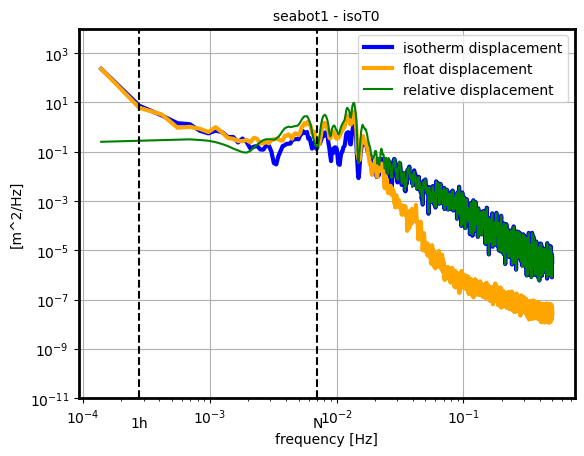

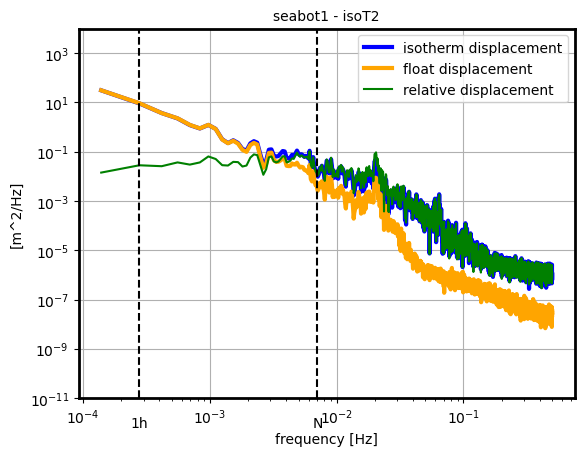

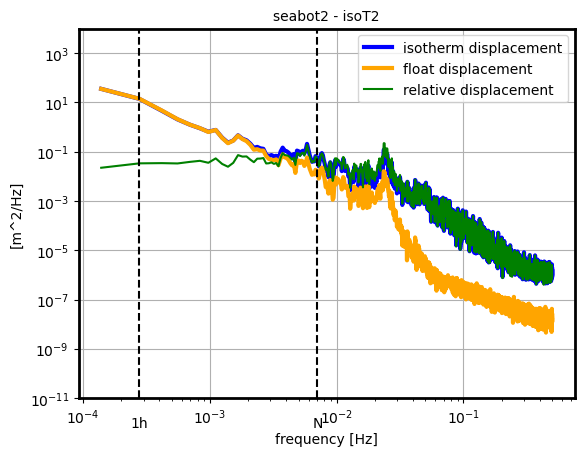

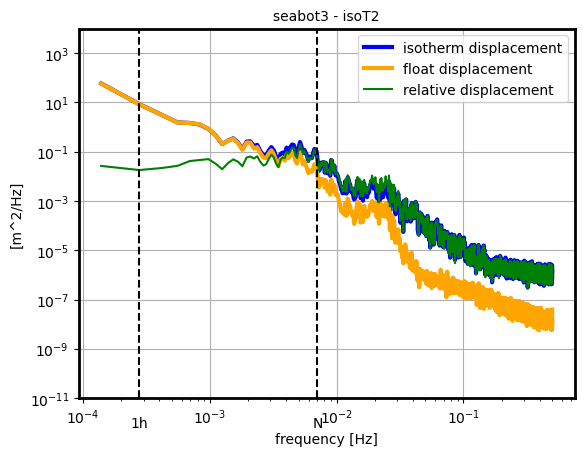

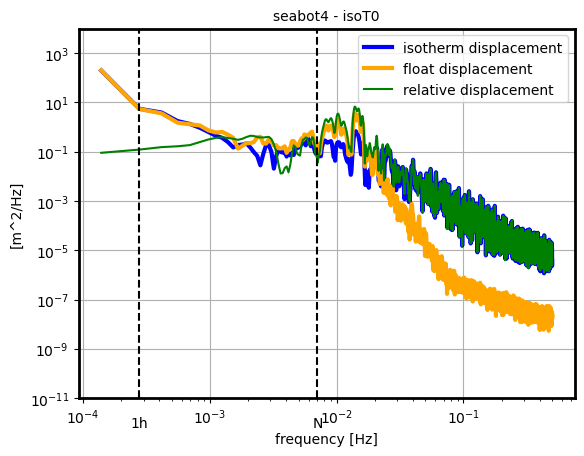

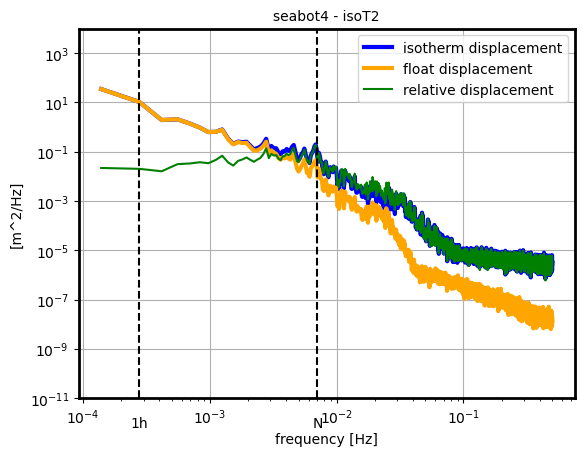

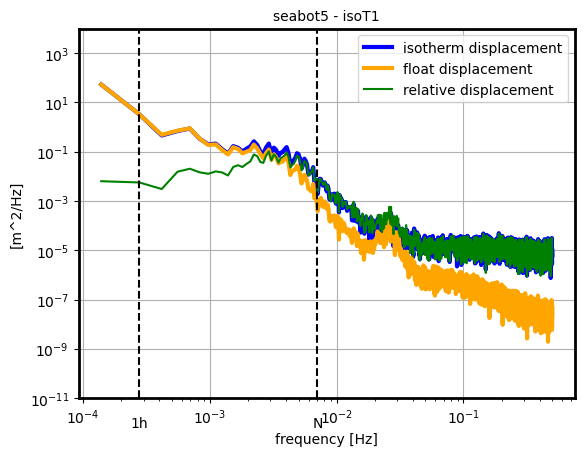

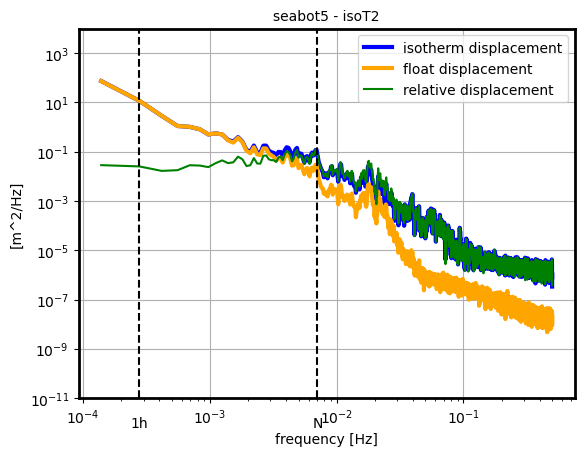

In [153]:
# isoT missions

for k, _E in Ed_T.items():

    fig, ax = plt.subplots(1,1) #, figsize=(5,7))
    if "isotherm_displacement" in _E:
        _E["isotherm_displacement"].plot(ax=ax, c="b", lw=3, label="isotherm displacement")
    _E["depth_anomaly"].plot(ax=ax, lw=3, c="orange", label="float displacement")
    if "relative_displacement" in _E:
        _E["relative_displacement"].plot(ax=ax, c="g", label="relative displacement")

    _add_labels(ax, N=N)
    ax.set_ylabel("[m^2/Hz]");
    ax.set_title(" - ".join(iM[k]))

Buoyancy period = 2.4 min


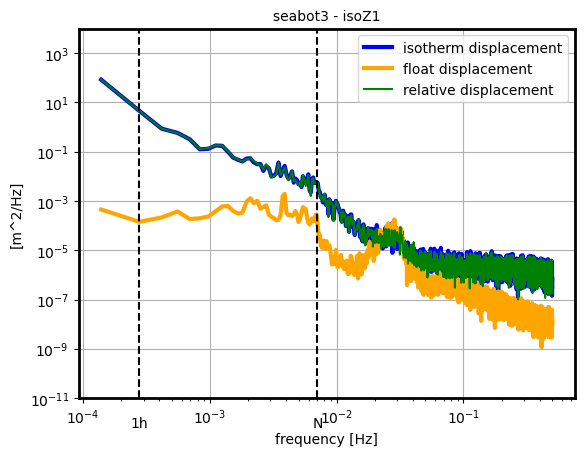

In [155]:
# isoZ missions

for k, _E in Ed_Z.items():

    fig, ax = plt.subplots(1,1) #, figsize=(5,7))
    if "isotherm_displacement" in _E:
        _E["isotherm_displacement"].plot(ax=ax, c="b", lw=3, label="isotherm displacement")
    _E["depth_anomaly"].plot(ax=ax, lw=3, c="orange", label="float displacement")
    if "relative_displacement" in _E:
        _E["relative_displacement"].plot(ax=ax, c="g", label="relative displacement")

    _add_labels(ax, N=N)
    ax.set_ylabel("[m^2/Hz]");
    ax.set_title(" - ".join(iM[k]))

Buoyancy period = 2.4 min


Text(0.5, 1.0, 'acceleration')

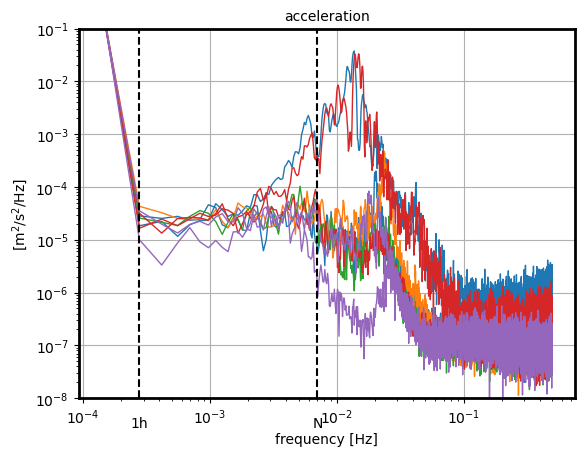

In [156]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

for k, _E in Ed_T.items():
    
    #E["isotherm_displacement"].plot(ax=ax, c="b", lw=3, label="isotherm displacement")
    _E["acceleration"].plot(ax=ax, lw=1, c=cp[iM[k][0]]["color"], label="/".join(k))
    #E["relative_displacement"].plot(ax=ax, c="g", label="relative displacement")

    #E["isotherm_displacement_natural"] = E["depth_anomaly"] / np.abs(He["H_w^f"])**2
    #E["isotherm_displacement_natural"].plot(ax=ax, c="b", lw=1, ls="--", label="isotherm displacement - natural")
    #E["depth_w"] = E["isotherm_displacement"] * np.abs(He["H_w^f"])**2
    #E["depth_w"].plot(ax=ax, c="b", lw=1, ls="-", label="depth - water resp.")

    #E["depth_p"] = E["pi_course"] * np.abs(He["H_p^r"])**2
    #E["depth_p"].plot(ax=ax, c="k", lw=1, ls="-", label="depth - piston resp.")

_add_labels(ax, N=N, legend=False)
ax.set_ylabel("[m$^2$/s$^2$/Hz]");
ax.set_ylim(1e-8, 1e-1)
ax.set_title("acceleration")

In [ ]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

#E["isotherm_displacement"].plot(ax=ax, c="b", lw=3, label="isotherm displacement")
E["depth_anomaly"].plot(ax=ax, lw=3, c="orange", label="float displacement")
#E["relative_displacement"].plot(ax=ax, c="g", label="relative displacement")

#E["isotherm_displacement_natural"] = E["depth_anomaly"] / np.abs(He["H_w^f"])**2
#E["isotherm_displacement_natural"].plot(ax=ax, c="b", lw=1, ls="--", label="isotherm displacement - natural")
E["depth_w"] = E["isotherm_displacement"] * np.abs(He["H_w^f"])**2
E["depth_w"].plot(ax=ax, c="b", lw=1, ls="-", label="depth - water resp.")

#E["depth_p"] = E["pi_course"] * np.abs(He["H_p^r"])**2
E["depth_p"] = E["pi_course_anomaly"] * np.abs(He["H_p^r"])**2 # same actually
E["depth_p"].plot(ax=ax, c="k", lw=1, ls="-", label="depth - piston resp.")

_add_labels(ax, N=N)
ax.set_ylabel("[m$^2$/Hz]");

- at low frequencies, water motions and piston displacements may equally explain float displacements
- around N, the float moves more than what may be attributed to piston displacements and the float is likely being moved by water motions
- at higher frequencies, the piston may be responsible for dispklacements up until frequencies of about 0.03 Hz (30s) where the effect of the piston drops sharply.

**Should we try to estimate transfer functions and compare them with theoretical ones ?**

In [ ]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

E["depth_anomaly"].plot(ax=ax, lw=1, c="orange", label="float displacement")
E["relative_displacement"].plot(ax=ax, lw=3, c="g", label="relative displacement")

E["relative_w"] = E["isotherm_displacement"] * np.abs(He["H_w^r"])**2
E["relative_w"].plot(ax=ax, c="b", lw=1, ls="-", label="relative - water resp.")

#E["relative_p"] = E["pi_course"] * np.abs(He["H_p^r"])**2
E["relative_p"] = E["pi_course_anomaly"] * np.abs(He["H_p^r"])**2
E["relative_p"].plot(ax=ax, c="k", lw=1, ls="-", label="relative - piston resp.")

_add_labels(ax, N=N)
ax.set_ylabel("[m$^2$/Hz]");

- relative motions have a flat spectrum up until about 0.01 Hz (100s) where it starts decaying with frequency.
- theory and inferred isotherm displacements predict relative displacements much weaker than those actually observed. This may be explained by the effect of the piston and/or and/or failure at estimating isotherm displacements and/or failure of theory. Piston displacements should induce larger relative displacements than those actually observed (??? bug in estimation of the reponse to water motions?).
- starting at N and provided estimates of the relative displacement is accurate, the piston cannot explain observed relative displacements and is therefore unlikely responsible for thoses

In [ ]:
fig, ax = plt.subplots(1,1) #, figsize=(5,7))

E["pi_course"].plot(ax=ax, lw=3, c="k", label="piston displacement")
#E["relative_displacement"].plot(ax=ax, lw=3, c="g", label="relative displacement")

E["piston_req"] = E["isotherm_displacement"] * np.abs(He["H_w^r"]/He["H_p^r"])**2
E["piston_req"].plot(ax=ax, c="0.5", lw=1, ls="-", label="piston displacement, required")

_add_labels(ax, N=N)
#ax.set_ylabel("[m$^2$/Hz]");
ax.set_ylim(1e-20, 1e-5)

- if theory holds, the piston is moving much more than what is required to hold an isothermal behavior

In [ ]:
np.sqrt(f.piston.A/np.pi)*2, f["V"]

In [ ]:
fig, ax = plt.subplots(1,1)

E["ka_velocity"].plot(ax=ax, color="orange", lw=3, label="float velocity")
E["velocity_water"].plot(ax=ax, color="b", lw=3, label="isotherm velocity")
E["velocity_relative"].plot(ax=ax, color="g", label="relative velocity")

_add_labels(ax, N=N)
#ax.set_ylabel("[m$^2$/Hz]");
ax.set_ylim(1e-10, 1e-1)

Kalman depth vs raw depth

In [ ]:
fig, ax = plt.subplots(1,1)

E["ka_depth"].plot(ax=ax, lw=3, label="kalman")
E["de_depth"].plot(ax=ax, lw=3, label="raw depth")
E["depth_difference"].plot(ax=ax, lw=1, label="difference")
#E["velocity_relative"].plot(ax=ax, color="g", label="relative velocity")

_add_labels(ax, N=N)
#ax.set_ylabel("[m$^2$/Hz]");
ax.set_ylim(1e-9, 1e4)

The noise floor starts at 0.05 Hz (20 seconds)

In [ ]:
# check piston displacement and parseval
df["pi_course"].plot()

---

## dynamical equation reconstruction

- level 0: $z_f$, water motions left as residual
- level 1: $z_r$ (with uncertainty around relation motion estimations)

In [ ]:
from freshwater.eos import Eos
import gsw

In [16]:
list(Dc)

[('test_guerledan_2024_10_08', 'seabot1'),
 ('test_guerledan_2024_10_08', 'seabot2'),
 ('test_guerledan_2024_10_08', 'seabot3'),
 ('test_guerledan_2024_10_08', 'seabot4'),
 ('test_guerledan_2024_10_08', 'seabot5'),
 ('test_guerledan_2024_10_10a', 'seabot3'),
 ('test_guerledan_2024_10_10a', 'seabot4'),
 ('test_guerledan_2024_10_10a', 'seabot5'),
 ('test_guerledan_2024_10_10b', 'seabot1'),
 ('test_guerledan_2024_10_10b', 'seabot2'),
 ('test_guerledan_2024_10_10b', 'seabot3'),
 ('test_guerledan_2024_10_10b', 'seabot4'),
 ('test_guerledan_2024_10_10b', 'seabot5'),
 ('test_guerledan_2024_10_11', 'seabotX')]

In [65]:
#df = Dc[('test_guerledan_2024_10_11', 'seabotX')]
df = Dcore[('test_guerledan_2024_10_11', 'seabotX')]
df = Dcore[('test_guerledan_2024_10_10a', 'seabot3')]
df.columns

Index(['ka_velocity', 'ka_depth', 'ka_offset', 'ka_chi', 'ka_chi2', 'ka_cz',
       'ka_volume_air', 'ka_offset_total', 'ka_variance0', 'ka_variance1',
       'ka_variance2', 'ka_variance3', 'ka_variance4', 'ka_variance5',
       'ka_valid', 'ka_time_since_start', 'te_temperature',
       'te_time_since_start', 'pi_position', 'pi_position_set_point',
       'pi_switch_top', 'pi_switch_bottom', 'pi_enable', 'pi_motor_sens',
       'pi_state', 'pi_motor_speed_set_point', 'pi_motor_speed',
       'pi_battery_voltage', 'pi_motor_current', 'pi_time_since_start',
       'de_depth', 'de_velocity', 'de_zero_depth_pressure', 'de_pressure',
       'de_time_since_start', 'depth_filtered', 'velocity_filtered',
       'pi_course', 'pi_volume', 'depth_anomaly', 'velocity_float',
       'temperature_anomaly', 'relative_displacement', 'isotherm_displacement',
       'velocity_water', 'velocity_relative', 'pi_course_anomaly'],
      dtype='object')

In [66]:
# init eos to get density

df['depth'] = df['ka_depth']
df['velocity'] = df['ka_velocity']
df['temperature'] = df['te_temperature']

# gsw: not adequate for salinities lower than 30psu
#import gsw
df['salinity'] = 0.
df['lon'], df['lat'] = sb.g_lon, sb.g_lat
df.sw.init()
df["rho_water_gsw"] = gsw.density.rho(df.SA, df.CT, df.pressure)
#df["alpha_water"] = gsw.alpha(df.SA, df.CT, df.pressure) # 1/K, varies from 1 to 1.6 10^-4 1/dbar !! nonlinear relationship ...
#
from freshwater.eos import Eos
e = Eos(t=df["temperature"], s=0., p= 1+df['depth']/10)
df["rho_water"] = e.rho

rho_bar = df["rho_water"].mean()

some values of longitude and latitudes are NaN, you may want to fill in with correct values


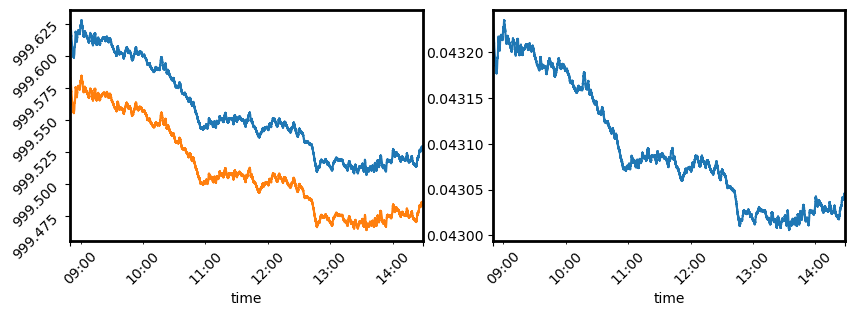

In [67]:
fig, axes = plt.subplots(1,2, figsize=(10,3), gridspec_kw=dict(wspace=.2))
ax = axes[0]
df["rho_water"].plot(ax=ax, label="correct formula")
df["rho_water_gsw"].plot(ax=ax, label="gsw")
ax.tick_params(which="both", labelrotation=45)
ax = axes[1]
(df["rho_water"] - df["rho_water_gsw"]).plot(ax=ax, label="difference")
ax.tick_params(axis="x", which="both", labelrotation=45)

In [68]:
def update_residual(ds):
    """ update inplace the residual"""
    ds["dyn_residual"] = (
        ds["dyn_acceleration"] 
        + ds["dyn_drag"] 
        + ds["dyn_buoy_piston"]
        + ds["dyn_buoy_float"]
        + ds["dyn_trapped_air"]
        + ds["dyn_buoy_water"] 
    )

dyn = [
    "dyn_acceleration", 
    "dyn_drag", 
    "dyn_buoy_piston",
    "dyn_buoy_float", 
    "dyn_trapped_air", 
    "dyn_buoy_water", 
    "dyn_residual",
]

In [69]:
ds = df[["velocity", "depth", "pi_volume", "rho_water", "temperature"]].to_xarray()

g = 9.81
p_atm = 10 # dbar
cm3 = 1e-6

sc = f["V"]/cm3/g

# estimate acceleration
ds["acceleration"] = ds["velocity"].differentiate("time", datetime_unit="1s")
a = f["a"] * .25
ds["dyn_acceleration"] = -(1+a)*ds["acceleration"] *sc

# estimate drag
ds["c_d"] = f.get_cd(-ds["velocity"], 0.)
ds["dyn_drag"] = ds.c_d * (-ds["velocity"]) *sc

# estimate buoyancy forces
ds["p_Pa"] = g*rho_bar*ds["depth"] # Pa
ds["p_dbar"] = ds["p_Pa"]/1e4 # dbar

# 
ds["dyn_buoy_water"] = -g*(ds["rho_water"]-rho_bar)/rho_bar *sc

# f.gamma # 1/dbar
#ds["rho_f"] = f.rho(z=-ds["depth"], waterp=w)
#alpha_f = 11e-5
alpha_f = 7e-5
#alpha_f = 0.
_dm = 5 * alpha_f * f["V"] /cm3
print(f"equivalent mass change for a 5 degC temperature change: {_dm:.2f} g")
ds["dyn_buoy_float"] = g*(
    f.gamma*(ds["p_dbar"]-ds["p_dbar"].mean())
    -alpha_f*(ds["temperature"]-ds["temperature"].mean())
) *sc

ds["dyn_buoy_piston"] = -g*ds["pi_volume"]/f["V"] *sc

ds["dyn_trapped_air"] = ds["dyn_buoy_piston"]*0.
ds["dyn_trapped_air"] = -(g*p_atm/(p_atm + ds["p_dbar"])*10*cm3/f["V"]) *sc
#ds["dyn_trapped_air"] = ds["dyn_trapped_air"] - ds["dyn_trapped_air"].isel(time=0)

update_residual(ds)

# offset piston equilibrium by a constant
#ds["dyn_buoy_piston"] = ds["dyn_buoy_piston"] - ds["dyn_residual"].isel(time=0)
ds["dyn_buoy_piston"] = ds["dyn_buoy_piston"] - ds["dyn_residual"].mean("time")

update_residual(ds)

equivalent mass change for a 5degC temperature change: 4.08 g


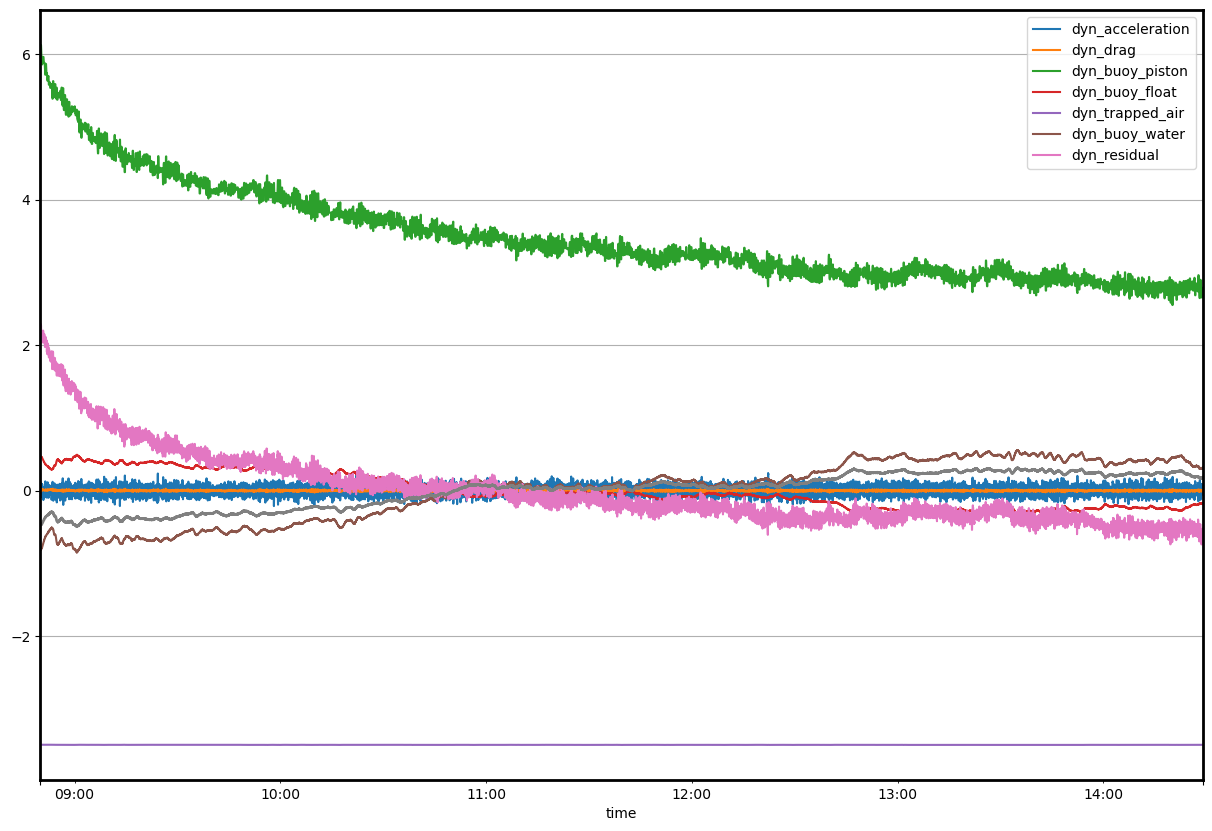

In [70]:
_df = ds.to_dataframe()

fig, ax = plt.subplots(figsize=(15,10))
_df[dyn].plot(ax=ax)

if False:
    dyn_air = -(g*p_atm/(p_atm + _df["p_dbar"])*10*cm3/f["V"]) *sc
    #dyn_air = dyn_air - dyn_air.iloc[0]
    dyn_air.plot(ax=ax, color="k", lw=2)

if True:
    _alpha = 7e-5 # 1/K
    dyn_therm = (g*_alpha*(_df["temperature"]-_df["temperature"].mean())) *sc
    #dyn_air = dyn_air - dyn_air.iloc[0]
    dyn_therm.plot(ax=ax, color="0.5", lw=2)

ax.grid()

<Axes: xlabel='time'>

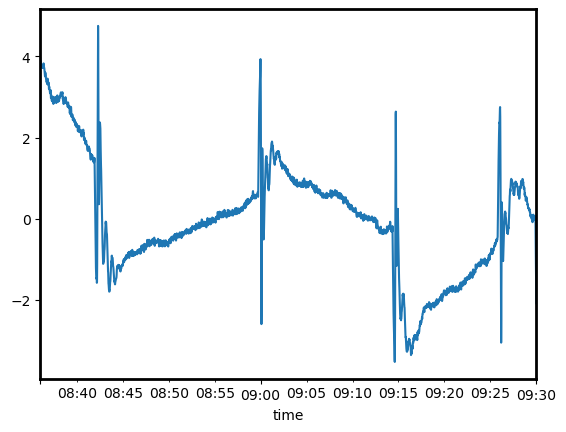

In [61]:
#_s = (_df["dyn_residual"] * (p_atm + _df["p_dbar"])/p_atm /g *f["V"] /cm3)
#_s = (_df["dyn_residual"] * (p_atm + _df["p_dbar"])/p_atm)
_s = _df["dyn_residual"] 
_s.plot()

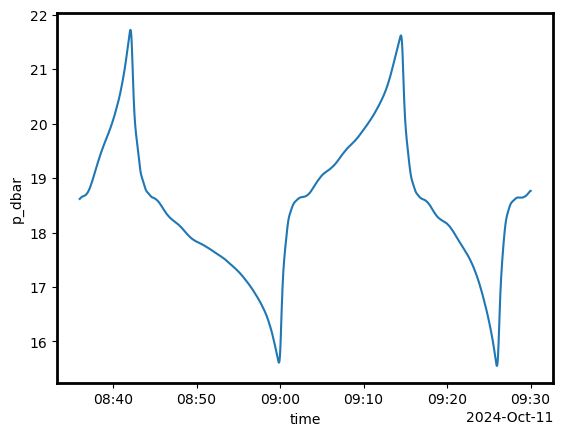

In [62]:
ds["p_dbar"].plot()

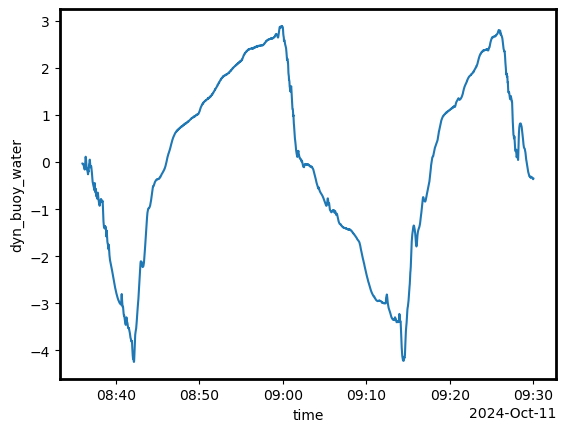

In [63]:
ds["dyn_buoy_water"].plot()

The **thermal diffusivity** of a material, denoted by \( \alpha \), measures how quickly heat diffuses through a material and is defined as:

\[
\alpha = \frac{k}{\rho c_p}
\]

Where:
- \( k \) is the thermal conductivity (W/m·K),
- \( \rho \) is the density (kg/m³),
- \( c_p \) is the specific heat capacity (J/kg·K).

For aluminium, the typical values are:
- Thermal conductivity, \( k \): ~237 W/m·K,
- Density, \( \rho \): ~2700 kg/m³,
- Specific heat capacity, \( c_p \): ~900 J/kg·K.

Using these values, we can calculate the thermal diffusivity:

\[
\alpha = \frac{237}{2700 \times 900}
\]

Let me calculate that for you.

The thermal diffusivity of aluminium is approximately \( 9.75 \times 10^{-5} \, \text{m}^2/\text{s} \).

In [ ]:
# perform estimation of unknowns

In [ ]:
dm = -np.arange(0,10e-3,1e-4)
w = f.get_terminal_velocity(f, dm)

fig, ax = plt.subplots(1,1)
ax.plot(dm*1e3, w*1e2, lw=4)
ax.set_xlabel("dm [g]")
ax.set_ylabel("w [cm/s]")
ax.grid()

In [ ]:
Need to show depth and velocity

In [73]:
from scipy.optimize import fsolve
g = 9.81

In [92]:
def get_terminal_velocity(self, dm):
    """ from a mass offset compute the terminal velocity that balances drag

    Parameters:
    -----------
    dm: float
        mass offset [kg]
    """        
    def _f(w):
        cd = self.get_cd(w, 0.)
        return g * dm + self["m"] * cd * w 
    if isinstance(dm, float) or isinstance(dm, int):
        w0 = 0.
        return fsolve(_f, w0)[0]
    else:
        w0 = np.zeros_like(dm)
        return fsolve(_f, w0)

f.get_terminal_velocity = get_terminal_velocity

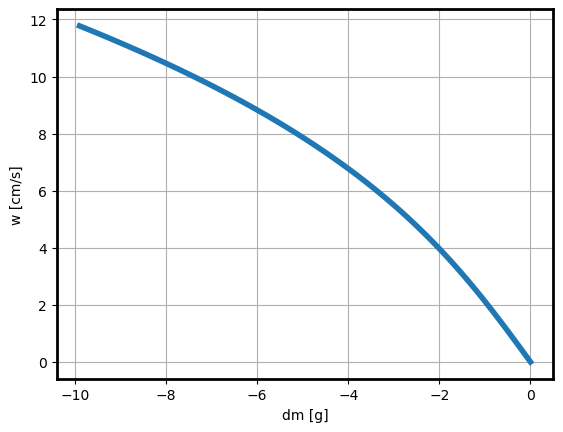

In [198]:
fig, ax = plt.subplots(1,1)
_df["dyn_acceleration"].hvplot()

:Curve   [time]   (dyn_acceleration)

In [ ]:
p=None
if show_hv:
    _df = ds[dyn].to_dataframe()
    p = _df.hvplot(title="dynamical reconstruction [m/s2]")
p

In [192]:
p

:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [ ]:
# this what we do if we didn't know temperature and it would be wrong because 
# it would not faithfully account for density of surrounding water
#_w = w.at(z=ds["depth"])
#ds["rho_water"] = _w["rho"]
# if we use temperature instead

#rho_ref = f["m"]/f["V"]
rho_w_mean = ds["rho_water"].mean()
rho_f_mean = ds["rho_f"].mean()
ds["dyn_buoy_water"] = -g*(ds["rho_water"]-rho_w_mean)/rho_f_mean
ds["dyn_buoy_float"] =  g*(ds["rho_f"]-rho_f_mean)/rho_f_mean
ds["dyn_buoy_piston"] = -g*ds["pi_volume"]/f["V"]

ds["dyn_trapped_air"] = ds["dyn_buoy_piston"]*0.

# estimate residual
def add_residual(ds):
    ds["dyn_residual"] = (
        ds["dyn_acceleration"] + ds["dyn_drag"] 
        + ds["dyn_buoy_water"] + ds["dyn_buoy_float"] + ds["dyn_buoy_piston"]
        + ds["dyn_trapped_air"]
    )
# enforce null average
add_residual(ds)
ds["dyn_buoy_piston"] = ds["dyn_buoy_piston"] - ds["dyn_residual"].mean()
add_residual(ds)

dyn = [
    "dyn_acceleration", "dyn_drag", 
    "dyn_buoy_water", "dyn_buoy_float", "dyn_buoy_piston",
    "dyn_trapped_air", 
    "dyn_residual",
]

In [ ]:
# speeds are so low (std of about 1-2 mm/s) that the drag is close to 0.038 all time
#ds["velocity"].std()
#ds["c_d"].to_dataframe().drop(columns=["z", "z_bg"]).hvplot()

In [ ]:
# check drag (student fits)
_u = .3
f.get_cd(_u, 0.) * _u * f.m  # in N

In [ ]:
#show_hv = True

In [ ]:
_a = 1e-3
_v = _a * f.V/g /fl.cm3 
print(f"an acceleration of {_a:.0e} m/s^2 corresponds to a volume difference of {_v:.02f} cm3")

Drag may be exagerated if the float follows isotherms (as it is to some extent the case for 5 min buoyancy oscillations).

In [ ]:
ds_low = ds.resample(time="20T").mean()

p=None
if show_hv:
    _df = ds_low[dyn].to_dataframe()
    p = _df.hvplot(title="dynamical reconstruction [m/s2]")
p

In [ ]:
# trapped air estimation

air = ds_low["dyn_residual"] * f.V/g /fl.cm3 
air = air - air.min()
air = air.rename("trapped_air")
air.attrs.update(unit="cm^3")

fig, ax = plt.subplots(1,1)
air.plot()
ax.grid()

In [ ]:
ds["v_air"] = air.interp(time=ds.time) * fl.cm3
ds["dyn_trapped_air"] = -g * ds["v_air"]/f.V
add_residual(ds)

In [ ]:
p=None
if show_hv:
    _df = ds[dyn].to_dataframe()
    p = _df.drop(columns=["z", "z_bg"]).hvplot(title="dynamical reconstruction [m/s2]")
p

In [ ]:
# should high pass filter temporally

fig, ax = plt.subplots(1,1)

r = ds["dyn_residual"] - ds["dyn_drag"]
ax.scatter(ds["dyn_drag"], r, s=1)

lim = 7e-3
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_aspect("equal")
ax.grid()

In [ ]:
def evaluate_closure(ds, terms):
    
    # global closure
    residual = sum([ds[t] for t in terms])
    S2 = float( (residual**2).mean() )
    
    A2 = {t: float((ds[t]**2).mean()) for t in terms}
    
    SA2 = {}
    for t in terms:
        _terms = [_t for _t in terms if _t is not t]
        residual_a = sum([ds[_t] for _t in _terms])
        SA2[t] = float((residual_a**2).mean())
        
    # explained part
    Ex = {t: A2[t] - S2 + SA2[t] for t in terms}
    Er = {t: A2[t] + S2 - SA2[t] for t in terms}
    
    return S2, A2, SA2, Ex, Er
    
_terms = [
    "dyn_acceleration", "dyn_drag", 
    "dyn_buoy_water", "dyn_buoy_float", "dyn_buoy_piston",
]
S = evaluate_closure(ds, _terms)
S

In [ ]:
key = list(Dc)[1]
print(key)
df = Dc[key]

fig, ax = plt.subplots(1,1)

delays = ["0s", "-2s", "-4s"]
_colors = pin.get_cmap_colors(len(delays))

for delay, c in zip(delays, _colors):
    _df = df.copy()
    _df["temperature"] = _df["temperature"].shift(freq=delay) # avance
    #_df.plot.scatter("temperature","depth", s=1, c=c, ax=ax, label=delay)
    ax.plot(_df.temperature, _df.depth, color=c, label=delay)

ax.invert_yaxis()
ax.grid()
ax.legend()
ax.set_xlim(None,10)

#### 2. low-pass filter depth instead

seems to behave similarly, 2s seconds seems a reasonable choice

In [ ]:
df = DF[0]

fig, ax = plt.subplots(1,1)

taus = [2, 3, 4]
_colors = pin.get_cmap_colors(len(taus))

for tau, c in zip(taus, _colors):
    _df = df.copy()
    append_depth_filtered(_df, tau)
    ax.plot(_df.temperature, _df.depth_filtered, label=f"tau={tau}")

ax.invert_yaxis()
ax.grid()
ax.legend()